# 06. Transfer Learning with TensorFlow Part 3: Scaling up (🍔👁 Food Vision mini)

Önceki iki not defterinde (transfer öğrenimi 1. bölüm: özellik çıkarma ve 2. bölüm: ince ayar) transfer öğreniminin gücünü gördük.

Artık daha küçük modelleme deneylerimizin işe yaradığını biliyoruz, daha fazla veriyle işleri bir adım öteye taşımanın zamanı geldi.

Bu, makine öğrenimi ve derin öğrenmede yaygın bir uygulamadır: daha büyük miktarda veriye ölçeklendirmeden önce az miktarda veri üzerinde çalışan bir model edinin.

🔑 Not: Makine öğrenimi uygulayıcıları mottosunu unutmadınız değil mi? "Deney, deney, deney."

Hayata geçen Food Vision projemize yaklaşma zamanı. Bu not defterinde, Food101 verilerinin 10 sınıfını kullanmaktan Food101 veri kümesindeki tüm sınıfları kullanmaya ölçeklendireceğiz.

Hedefimiz, orijinal Food101 makalesinin sonuçlarını %10 veri ile geçmek.

In [ ]:
# Are we using a GPU?
# If not, and you're in Google Colab, go to Runtime -> Change runtime type -> Hardware accelerator -> GPU
!nvidia-smi

Thu Jun 15 13:07:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install tensorflow


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached tensorflow-2.12.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (585.9 MB)
  Using cached flatbuffers-23.5.26-py2.py3-none-any.whl (26 kB)
  Using cached keras-2.12.0-py2.py3-none-any.whl (1.7 MB)
  Using cached protobuf-4.23.3-cp37-abi3-manylinux2014_x86_64.whl (304 kB)
  Using cached tensorboard-2.12.3-py3-none-any.whl (5.6 MB)
  Using cached tensorflow_estimator-2.12.0-py2.py3-none-any.whl (440 kB)
  Using cached google_auth_oauthlib-1.0.0-py2.py3-none-any.whl (18 kB)
  Using cached tensorboard_data_server-0.7.1-py3-none-manylinux2014_x86_64.whl (6.6 MB)
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimat

## Creating helper functions

In [ ]:
# Get helper functions file
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-06-15 13:07:25--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.3’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-06-15 13:07:25 (77.5 MB/s) - ‘helper_functions.py.3’ saved [10246/10246]



In [ ]:
import tensorflow as tf

In [ ]:
print(tf.__version__)

2.12.0


In [ ]:
# Import series of helper functions for the notebook (we've created/used these in previous notebooks)
from helper_functions import create_tensorboard_callback, plot_loss_curves, unzip_data, compare_historys, walk_through_dir

## 101 Food Classes: Working with less data

So far we've confirmed the transfer learning model's we've been using work pretty well with the 10 Food Classes dataset. Now it's time to step it up and see how they go with the full 101 Food Classes.

In the original Food101 dataset there's 1000 images per class (750 of each class in the training set and 250 of each class in the test set), totalling 101,000 imags.

We could start modelling straight away on this large dataset but in the spirit of continually experimenting, we're going to see how our previously working model's go with 10% of the training data.

This means for each of the 101 food classes we'll be building a model on 75 training images and evaluating it on 250 test image

## Downloading and preprocessing the data

In [ ]:
# Download data from Google Storage (already preformatted)
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = "101_food_classes_10_percent/train/"
test_dir = "101_food_classes_10_percent/test/"

--2023-06-15 13:10:08--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 172.217.218.128, 142.251.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.2’

101_food_classes_10 100%[===================>]   1.51G  38.5MB/s    in 40s     

2023-06-15 13:10:48 (39.2 MB/s) - ‘101_food_classes_10_percent.zip.2’ saved [1625420029/1625420029]



In [ ]:
# How many images/classes are there?
walk_through_dir("101_food_classes_10_percent")

There are 2 directories and 0 images in '101_food_classes_10_percent'.
There are 101 directories and 0 images in '101_food_classes_10_percent/test'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/prime_rib'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/huevos_rancheros'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/onion_rings'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/seaweed_salad'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/fried_calamari'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/paella'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_mousse'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/creme_brulee'.
There are 0 directories and 250 images in '101_food_classes_10_percent/test/chocolate_cake'.
There are 0 directories and 2

In [ ]:
# Setup data inputs
import tensorflow as tf
IMG_SIZE = (224, 224)
train_data_all_10_percent = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                                label_mode="categorical",
                                                                                image_size=IMG_SIZE)

test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=IMG_SIZE,
                                                                shuffle=False) # don't shuffle test data for prediction analysis

Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


# Train a big dog model with transfer learning on 10% of 101 food classes

* A ModelCheckpoint callback to save our progress during training, this means we could experiment with further training later without having to train from scratch every time

* Data augmentation built right into the model

* A headless (no top layers) EfficientNetB0 architecture from tf.keras.applications as our base model

* A Dense layer with 101 hidden neurons (same as number of food classes) and softmax activation as the output layer

* Categorical crossentropy as the loss function since we're dealing with more than two classes

* The Adam optimizer with the default settings

* Fitting for 5 full passes on the training data while evaluating on 15% of the test data

It seems like a lot but these are all things we've covered before in the Transfer Learning in TensorFlow Part 2: Fine-tuning notebook.

Let's start by creating the ModelCheckpoint callback.

Since we want our model to perform well on unseen data we'll set it to monitor the validation accuracy metric and save the model weights which score the best on that.



In [ ]:
# Create checkpoint callback
checkpoint_path = "101_classes_10_percent_data_model_checkpoint"
# Bu kod, TensorFlow kullanarak bir modelin eğitim sırasında belirli bir noktada kaydedilmesini sağlayan bir geri çağrı (callback) oluşturur
# .keras.callbacks.ModelCheckpoint sınıfı, modelin ağırlıklarını ve/veya tam modelini kaydetmek için kullanılır.
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,# : Kaydedilecek ağırlıkların veya modelin yolunu belirtir
                                                         save_weights_only=True, # Sadece modelin ağırlıklarının kaydedilmesini sağlar. Eğer False olarak ayarlanırsa, tam model kaydedilir
                                                         monitor='val_accuracy', # zlenecek metriği belirtir. Bu örnekte doğrulama (validation) veri seti üzerindeki doğruluk (accuracy) değeri takip edilecektir.
                                                         save_best_only=True) # Sadece en iyi değere sahip modellerin kaydedilmesini sağlar.



In [ ]:
# Import the required modules for model creation
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

# YENİ: TensorFlow'un (2.10) daha yeni sürümleri, veri büyütme için doğrudan tensorflow.keras.layers API'sini kullanabilir
data_augmentation = Sequential([
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomHeight(0.2),
    layers.RandomWidth(0.2),
    # preprocessing.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
],name='data_augmentation')

Güzel! data_augmentation Sequential modelini Functional API modelimize bir katman olarak ekleyebileceğiz. Bu şekilde, modelimizi daha sonra eğitmeye devam etmek istiyorsak, veri artırma zaten yerleşiktir. İşlevsel API modellerinden bahsetmişken, tf.keras.applications.efficientNetB0 kullanarak bir özellik çıkarma aktarım öğrenme modelini bir araya getirmenin zamanı geldi. temel modelimiz olarak. Temel modeli include_top=False parametresini kullanarak içe aktaracağız, böylece kendi çıktı katmanlarımıza, özellikle GlobalAveragePooling2D() (temel modelin çıktılarını, çıktı katmanı tarafından kullanılabilen bir şekle sıkıştırın) ve ardından bir Yoğun katman ekleyebiliriz.

In [ ]:
from keras.layers.serialization import activation
# Setup base model and freeze its Layers (this will exract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)# include_top = False diyerek modelimizin çıktı katmanını özeleştireceğimizi veya değiştireceğimizi modele belirttik
base_model.trainable  = False
# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(224, 224, 3), name="input_layer") # shape of input image
x = data_augmentation(inputs)# Girdileri data_augmentation katmanına verdik
x=base_model(x,training=False)
x = layers.GlobalAveragePooling2D(name='global_average_pooling')(x)
outputs = layers.Dense(len(train_data_all_10_percent.class_names),activation='softmax',name='output_layer')(x)
model = tf.keras.Model(inputs,outputs)

In [ ]:
# Get a summary of our model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, None, None, 3)    0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])
# fit the model
history_all_classes_10_percent = model.fit(train_data_all_10_percent,
                                           epochs=5,
                                           validation_data=test_data,
                                           validation_steps=int(0.15*len(test_data)),
                                           callbacks=[checkpoint_callback]) # save best model weihgst to file

Epoch 1/5
237/237 [==============================] - 120s 424ms/step - loss: 3.3877 - accuracy: 0.2688 - val_loss: 2.5454 - val_accuracy: 0.4407
Epoch 2/5
237/237 [==============================] - 78s 322ms/step - loss: 2.2021 - accuracy: 0.4953 - val_loss: 2.0652 - val_accuracy: 0.5095
Epoch 3/5
237/237 [==============================] - 69s 290ms/step - loss: 1.8274 - accuracy: 0.5669 - val_loss: 1.9127 - val_accuracy: 0.5201
Epoch 4/5
237/237 [==============================] - 62s 260ms/step - loss: 1.6068 - accuracy: 0.6121 - val_loss: 1.8118 - val_accuracy: 0.5376
Epoch 5/5
237/237 [==============================] - 60s 253ms/step - loss: 1.4458 - accuracy: 0.6473 - val_loss: 1.7906 - val_accuracy: 0.5379


In [ ]:
# Evaluate model
results_feature_extraction_model = model.evaluate(test_data)
results_feature_extraction_model

790/790 [==============================] - 79s 100ms/step - loss: 1.5826 - accuracy: 0.5857


[1.5826135873794556, 0.585663378238678]

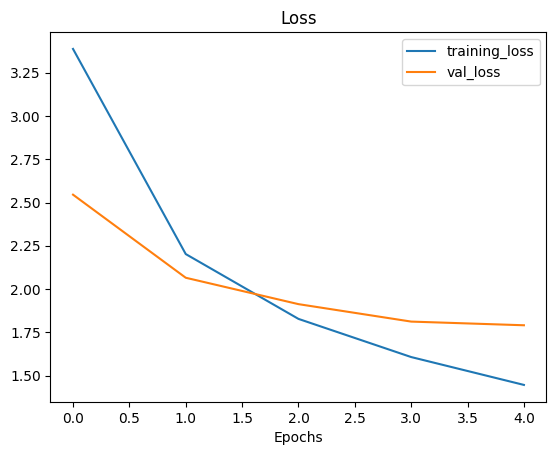

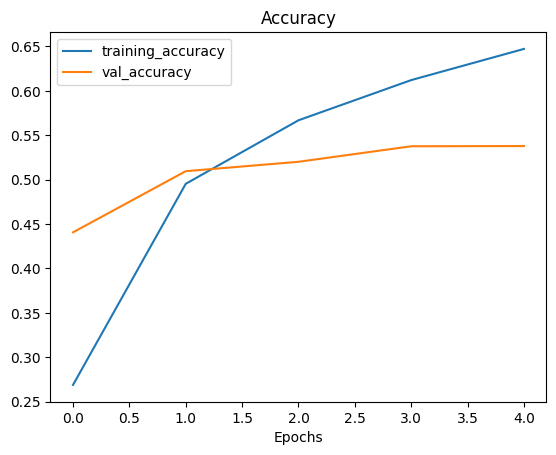

In [ ]:
plot_loss_curves(history_all_classes_10_percent)

## Fine-tuning

Özellik çıkarma aktarımlı öğrenme modelimiz iyi performans gösteriyor. Neden temel modelde birkaç katmanda ince ayar yapmayı denemiyoruz ve herhangi bir gelişme elde edip etmeyeceğimize bakmıyoruz? İyi haber şu ki, ModelCheckpoint geri araması sayesinde zaten iyi performans gösteren modelimizin kayıtlı ağırlıklarını elde ettik, bu nedenle ince ayar herhangi bir fayda sağlamazsa geri dönebiliriz. Temel modelde ince ayar yapmak için önce donmuş olanların tümünü çözerek eğitilebilir özelliğini True olarak ayarlayacağız. Ardından, nispeten küçük bir eğitim veri setimiz olduğu için, son 5 hariç her katmanı yeniden dondurarak onları eğitilebilir hale getireceğiz.

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable=True
# Refreeze every layer except for the Last 5 son 5 katmanı çözeceğiz
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with Lower Learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),# ne kadar fazla katman çözersek öğrenme oranını ayno oranda düşürmemiz lazım
              metrics=['accuracy'])

In [ ]:
# What Layers in the model are trainable
for layer in model.layers:
  print(layer.name,layer.trainable)

input_layer True
data_augmentation True
efficientnetb0 True
global_average_pooling True
output_layer True


In [ ]:
# Check which layers are trainable
for layer_number , layer in enumerate(base_model.layers):
  print(layer_number,layer.name,layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
# Fine-tune for 5 more epochs
fine_tune_epochs = 10 # model has already done 5 epochs, this is the total number of epochs we're after (5+5=10)

history_all_classes_10_percent_fine_tune = model.fit(train_data_all_10_percent,
                                                     epochs=fine_tune_epochs,
                                                     validation_data=test_data,
                                                     validation_steps=int(0.15 * len(test_data)), # validate on 15% of the test data
                                                     initial_epoch=history_all_classes_10_percent.epoch[-1]) # start from previous last epoch

Epoch 5/10
237/237 [==============================] - 67s 242ms/step - loss: 1.2016 - accuracy: 0.6858 - val_loss: 1.6913 - val_accuracy: 0.5593
Epoch 6/10
237/237 [==============================] - 56s 231ms/step - loss: 1.0987 - accuracy: 0.7080 - val_loss: 1.7168 - val_accuracy: 0.5551
Epoch 7/10
237/237 [==============================] - 62s 261ms/step - loss: 1.0221 - accuracy: 0.7287 - val_loss: 1.7272 - val_accuracy: 0.5553
Epoch 8/10
237/237 [==============================] - 49s 205ms/step - loss: 0.9519 - accuracy: 0.7426 - val_loss: 1.7169 - val_accuracy: 0.5516
Epoch 9/10
237/237 [==============================] - 47s 197ms/step - loss: 0.8811 - accuracy: 0.7596 - val_loss: 1.7595 - val_accuracy: 0.5440
Epoch 10/10
237/237 [==============================] - 59s 246ms/step - loss: 0.8511 - accuracy: 0.7694 - val_loss: 1.7502 - val_accuracy: 0.5469


In [ ]:
# Evaluate fine-tuned model on the whole test dataset
results_all_classes_10_percent_fine_tune = model.evaluate(test_data)
results_all_classes_10_percent_fine_tune

790/790 [==============================] - 72s 91ms/step - loss: 1.5003 - accuracy: 0.6018


[1.500348687171936, 0.601821780204773]

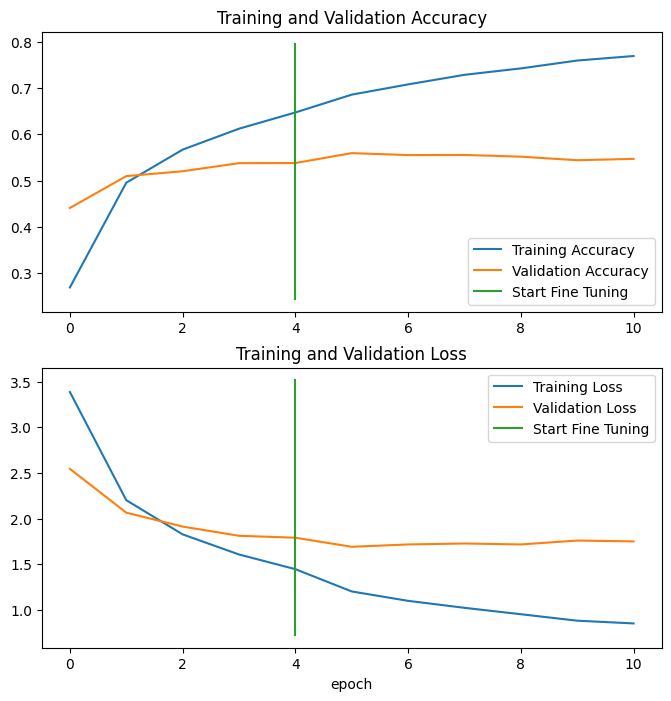

In [ ]:
compare_historys(original_history=history_all_classes_10_percent,
                 new_history=history_all_classes_10_percent_fine_tune,
                 initial_epochs=5)

### Saving our trained model

* Modelimizi harici bir ıygulamada kulanmak için kaydetmemiz ve bir yere indirmemiz gereklidir

In [ ]:
model.save('./models/EfficientNetB7_xx.h5py')


TypeError: ignored

### Evaluating the performance of the big dog model across all different classes